# **SEL-NNML Gaussian Process (GP) Tuning - Kaggle Heart Failure Prediction Dataset**

This notebook implements `Stacking Ensemble Learning with a Neural Network Meta-Learner (SEL-NNML)` model on the `Kaggle Heart Failure Prediction dataset (KHFPD)` .

## **0. Global Configuration**

In [1]:
# Random state for reproducibility
RANDOM_STATE = 42

# Data splitting configuration
TEST_SIZE = 0.2

# Cross-validation configuration
CV_FOLDS = 5

# Hyperparameter tuning configuration
OPTIMIZATION_ITERATIONS = 100
OPTIMIZATION_METRIC = 'accuracy'

# Parallel processing configuration
N_JOBS = -1 

# Dataset configuration
DATASET_PATH = '../../datasets/processed/ds1_kaggle_heart_clean.csv'
TARGET_COLUMN = 'HeartDisease'

print('Global configuration loaded successfully!')
print(f'Random State: {RANDOM_STATE}')
print(f'Test Size: {TEST_SIZE}')
print(f'CV Folds: {CV_FOLDS}')
print(f'Optimization Iterations: {OPTIMIZATION_ITERATIONS}')
print(f'Optimization Metric: {OPTIMIZATION_METRIC}')

Global configuration loaded successfully!
Random State: 42
Test Size: 0.2
CV Folds: 5
Optimization Iterations: 100
Optimization Metric: accuracy


## **1. Import Library**

In [2]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_STATE)
import matplotlib.pyplot as plt
import optuna as opt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

## **2. Load Dataset**

In [3]:
df = pd.read_csv(DATASET_PATH)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              746 non-null    int64  
 1   Sex                              746 non-null    bool   
 2   RestingBP                        746 non-null    int64  
 3   Cholesterol                      746 non-null    int64  
 4   FastingBS                        746 non-null    bool   
 5   MaxHR                            746 non-null    int64  
 6   ExerciseAngina                   746 non-null    bool   
 7   Oldpeak                          746 non-null    float64
 8   HeartDisease                     746 non-null    bool   
 9   ChestPainType_ATA                746 non-null    bool   
 10  ChestPainType_NAP                746 non-null    bool   
 11  RestingECG_Normal                746 non-null    bool   
 12  ST_Slope_Flat         

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,RestingECG_Normal,ST_Slope_Flat,ST_Slope_Up,Male_ST_Slope_Flat,ChestPainType_ASY_ST_Slope_Flat,Male_ChestPainType_ASY
0,40,True,140,289,False,172,False,0.0,False,True,False,True,False,True,False,False,False
1,49,False,160,180,False,156,False,1.0,True,False,True,True,True,False,False,False,False
2,37,True,130,283,False,98,False,0.0,False,True,False,False,False,True,False,False,False
3,48,False,138,214,False,108,True,1.5,True,False,False,True,True,False,False,True,False
4,54,True,150,195,False,122,False,0.0,False,False,True,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,45,True,110,264,False,132,False,1.2,True,False,False,True,True,False,True,False,False
742,68,True,144,193,True,141,False,3.4,True,False,False,True,True,False,True,True,True
743,57,True,130,131,False,115,True,1.2,True,False,False,True,True,False,True,True,True
744,57,False,130,236,False,174,False,0.0,True,True,False,False,True,False,False,False,False


## **3. Data Preparation**

- Split the data into desired training and testing
- After that, Scaling the data using Min-Max Normalization

In [4]:
# Split dataset
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [5]:
# Min-Max Scaling
# Separate numeric and boolean columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns  # includes one-hot from get_dummies

# Initialize scaler and fit_transform only on numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (without modification)
X_train = pd.concat([X_train_scaled, X_train[bool_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

## **4. Base Model Hyperparameter Tuning with GP and Cross Validation**

In [6]:
# Base Model Hyperparameter Tuning with GP and CV Function
def base_model_tuning(model_name, x_train, y_train, iterations=100, metric_compare='accuracy'):
    if model_name == 'Logistic Regression':
        def objective(trial):
            solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'])
            C = trial.suggest_float('C', 1e-4, 10, log=True)
            model = LogisticRegression(solver=solver, C=C, max_iter=1000, random_state=RANDOM_STATE, n_jobs=N_JOBS, warm_start=True)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='GP Tuning: Logistic Regression', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = LogisticRegression(**best_params, max_iter=1000, random_state=RANDOM_STATE, n_jobs=N_JOBS, warm_start=True)
    
    elif model_name == 'Decision Tree':
        def objective(trial):
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            model = DecisionTreeClassifier(criterion=criterion, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()

        study = opt.create_study(study_name='GP Tuning: Decision Tree', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
        
    elif model_name == 'Random Forest':
        def objective(trial):
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            n_estimators = trial.suggest_int('n_estimators', 10, 100)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            model = RandomForestClassifier(criterion=criterion, max_features=max_features, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=RANDOM_STATE, n_jobs=N_JOBS)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='GP Tuning: Random Forest', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    
    elif model_name == 'K-Nearest Neighbors':
        def objective(trial):
            algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'brute'])
            n_neighbors = trial.suggest_int('n_neighbors', 3, 50)
            p = trial.suggest_int('p', 1, 2)
            model = KNeighborsClassifier(weights='uniform', algorithm=algorithm, n_neighbors=n_neighbors, p=p, n_jobs=N_JOBS)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='GP Tuning: K-Nearest Neighbors', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = KNeighborsClassifier(**best_params, weights='uniform', n_jobs=N_JOBS)
    
    elif model_name == 'Support Vector Machine':
        def objective(trial):
            kernel = trial.suggest_categorical('kernel', ['rbf', 'sigmoid', 'poly'])
            C = trial.suggest_float('C', 1e-4, 1e-2, log=True)
            degree = 3
            if kernel == 'poly':
                degree = trial.suggest_int('degree', 2, 5)
            model = SVC(kernel=kernel, gamma='scale', C=C, degree=degree, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='GP Tuning: Support Vector Machine', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = SVC(**best_params, gamma='scale', random_state=RANDOM_STATE)
    
    elif model_name == 'AdaBoost':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 10, 100)
            learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0, log=True)
            model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='GP Tuning: AdaBoost', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = AdaBoostClassifier(**best_params, random_state=RANDOM_STATE)
        
    elif model_name == 'Gradient Boosting':
        def objective(trial):
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            n_estimators = trial.suggest_int('n_estimators', 10, 100)
            learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            model = GradientBoostingClassifier(criterion='friedman_mse', loss='log_loss', max_features=max_features, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='GP Tuning: Gradient Boosting', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = GradientBoostingClassifier(**best_params, criterion='friedman_mse', loss='log_loss', random_state=RANDOM_STATE)
    
    print(f'\nBest Hyperparameters for {model_name} (using GPSampler):')
    print(best_params)
    
    return model

In [8]:
# Begin timing base models training
base_models_training_start = time.time()

### **4.1 Logistic Regression Hyperparameter Tuning**

In [9]:
logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

C:\Users\azhar\AppData\Local\Temp\ipykernel_1296\2322970220.py:10: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = opt.create_study(study_name='GP Tuning: Logistic Regression', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
[I 2025-10-02 22:26:09,542] A new study created in memory with name: GP Tuning: Logistic Regression


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:26:15,241] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.
[I 2025-10-02 22:26:20,159] Trial 1 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-02 22:26:26,169] Trial 2 finished with value: 0.7265686274509804 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-02 22:26:31,578] Trial 3 finished with value: 0.8137394957983192 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-02 22:26:31,628] Trial 4 finished with value: 0.8489775910364145 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-02 22:26:31,675] Trial 5 

### **4.2 Decision Tree Hyperparameter Tuning**

In [10]:
decision_tree = base_model_tuning('Decision Tree', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

C:\Users\azhar\AppData\Local\Temp\ipykernel_1296\2322970220.py:25: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = opt.create_study(study_name='GP Tuning: Decision Tree', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
[I 2025-10-02 22:26:56,817] A new study created in memory with name: GP Tuning: Decision Tree


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:26:56,939] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-02 22:26:57,029] Trial 1 finished with value: 0.8104061624649859 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-02 22:26:57,129] Trial 2 finished with value: 0.8087254901960785 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-02 22:26:57,211] Trial 3 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271

### **4.3 Random Forest Hyperparameter Tuning**

In [11]:
random_forest = base_model_tuning('Random Forest', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

C:\Users\azhar\AppData\Local\Temp\ipykernel_1296\2322970220.py:41: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = opt.create_study(study_name='GP Tuning: Random Forest', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
[I 2025-10-02 22:27:08,752] A new study created in memory with name: GP Tuning: Random Forest


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:27:08,908] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.
[I 2025-10-02 22:27:09,072] Trial 1 finished with value: 0.8590756302521008 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-10-02 22:27:09,218] Trial 2 finished with value: 0.8356022408963586 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-10-02 22:27:09,380] Trial 3 finished with value: 0.8456302521008402 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples

### **4.4 K-Nearest Neighbors Hyperparameter Tuning**

In [12]:
knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

C:\Users\azhar\AppData\Local\Temp\ipykernel_1296\2322970220.py:54: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = opt.create_study(study_name='GP Tuning: K-Nearest Neighbors', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
[I 2025-10-02 22:27:47,486] A new study created in memory with name: GP Tuning: K-Nearest Neighbors


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:27:47,550] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:27:47,723] Trial 1 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:27:47,771] Trial 2 finished with value: 0.8472969187675069 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:27:47,942] Trial 3 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:27:47,992] Trial 4 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:27:48,039] Trial 5 f

### **4.5 Support Vector Machine Hyperparameter Tuning**

In [13]:
svm = base_model_tuning('Support Vector Machine', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

C:\Users\azhar\AppData\Local\Temp\ipykernel_1296\2322970220.py:69: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = opt.create_study(study_name='GP Tuning: Support Vector Machine', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
[I 2025-10-02 22:28:06,164] A new study created in memory with name: GP Tuning: Support Vector Machine


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:28:06,236] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-10-02 22:28:06,285] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-10-02 22:28:06,337] Trial 2 finished with value: 0.5453221288515406 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-02 22:28:06,386] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-02 22:28:06,439] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-02 22:28:06,488] Trial 5 finished with valu

### **4.6 Adaptive Boosting Hyperparameter Tuning**

In [14]:
adaboost = base_model_tuning('AdaBoost', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

C:\Users\azhar\AppData\Local\Temp\ipykernel_1296\2322970220.py:81: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = opt.create_study(study_name='GP Tuning: AdaBoost', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
[I 2025-10-02 22:28:22,171] A new study created in memory with name: GP Tuning: AdaBoost


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:28:22,339] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-02 22:28:22,555] Trial 1 finished with value: 0.84390756302521 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-02 22:28:22,647] Trial 2 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-02 22:28:22,705] Trial 3 finished with value: 0.8388795518207284 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-02 22:28:22,892] Trial 4 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-

### **4.7 Gradient Boosting Hyperparameter Tuning**

In [15]:
gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

C:\Users\azhar\AppData\Local\Temp\ipykernel_1296\2322970220.py:98: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = opt.create_study(study_name='GP Tuning: Gradient Boosting', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
[I 2025-10-02 22:29:15,234] A new study created in memory with name: GP Tuning: Gradient Boosting


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:29:15,361] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.
[I 2025-10-02 22:29:15,516] Trial 1 finished with value: 0.83890756302521 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.83890756302521.
[I 2025-10-02 22:29:15,575] Trial 2 finished with value: 0.7028991596638656 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.83890756302521.
[I 2025-10-02 22:29:15,654] Trial 3 finished wi

### **4.8 Save Best Model for each Base Models**

In [16]:
# Final Base Model Fitting
base_logistic_regression = logistic_regression.fit(X_train, y_train)
base_decision_tree = decision_tree.fit(X_train, y_train)
base_random_forest = random_forest.fit(X_train, y_train)
base_knn = knn.fit(X_train, y_train)
base_svm = svm.fit(X_train, y_train)
base_adaboost = adaboost.fit(X_train, y_train)
base_gradient_boosting = gradient_boosting.fit(X_train, y_train)

# End timing base models training
base_models_training_end = time.time()

# Save base models total training time
base_models_training_time = base_models_training_end - base_models_training_start

# Base Models Storage
base_models = {
    'Logistic Regression': base_logistic_regression,
    'Decision Tree': base_decision_tree,
    'Random Forest': base_random_forest,
    'K-Nearest Neighbors': base_knn,
    'Support Vector Machine': base_svm,
    'AdaBoost': base_adaboost,
    'Gradient Boosting': base_gradient_boosting
}

# Show Base Model Hyperparameters
base_model_hyperparameters = pd.DataFrame(columns=['Model Name', 'Best Hyperparameters'])
base_model_hyperparameters['Model Name'] = [
                                        'Logistic Regression', 
                                        'Decision Tree', 
                                        'Random Forest', 
                                        'K-Nearest Neighbors', 
                                        'Support Vector Machine', 
                                        'AdaBoost', 
                                        'Gradient Boosting'
                                        ]
base_model_hyperparameters['Best Hyperparameters'] = [   
                                                base_logistic_regression.get_params(),
                                                base_decision_tree.get_params(), 
                                                base_random_forest.get_params(), 
                                                base_knn.get_params(), 
                                                base_svm.get_params(), 
                                                base_adaboost.get_params(), 
                                                base_gradient_boosting.get_params(),
                                                ]

base_model_hyperparameters

,Model Name,Best Hyperparameters
0,Logistic Regression,"{'C': 0.08257791600771174, 'class_weight': Non..."
1,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
2,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,K-Nearest Neighbors,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm..."
4,Support Vector Machine,"{'C': 0.01, 'break_ties': False, 'cache_size':..."
5,AdaBoost,"{'algorithm': 'deprecated', 'estimator': None,..."
6,Gradient Boosting,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."


## **5. Meta Model Hyperparameter Tuning with GP and Cross Validation**

The hyperparameters to be tuned are:
- Selection of the number and type of base models used
- Number of layers in the neural network: 1 - 5
- Number of neurons per layer: 10 - 100
- Learning rate behavior: Constant or Adaptive
- Learning rate value: 0.0001 - 0.01
- L2 Regularization value: 0.0001 - 0.01

Unchanged Preset hyperparameters:
- Activation function: ReLU
- Optimizer (Solver): Adam
- Epochs (Max Iter): 300

In [ ]:
# Meta Model (Stacking with MLP) Hyperparameter Tuning with GP and CV Function
def meta_model_tuning(models, x_train, y_train, x_test, y_test, iterations=100):
    def objective(trial):
        # Suggest which base models to include
        selected_estimators = []
        for name, model in models.items():
            use_model = trial.suggest_categorical(f'use_{name}', [True, False])
            if use_model:
                selected_estimators.append((name, model))
        # At least 2 base models required for stacking
        if len(selected_estimators) < 2:
            return 0.0

        n_layers = trial.suggest_int('n_layers', 1, 5)
        neurons = [trial.suggest_int(f'n_neurons_{i}', 10, 100) for i in range(n_layers)]
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
        learning_rate_init = trial.suggest_float('learning_rate_init', 0.0001, 0.01, log=True)
        alpha = trial.suggest_float('alpha', 0.0001, 0.01, log=True)

        meta_model = MLPClassifier(
            activation='relu',
            solver='adam',
            hidden_layer_sizes=tuple(neurons),
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            alpha=alpha,
            max_iter=300,
            random_state=RANDOM_STATE
        )

        stacking_model = StackingClassifier(
            estimators=selected_estimators,
            final_estimator=meta_model,
            cv=CV_FOLDS,
            n_jobs=N_JOBS
        )

        stacking_model.fit(x_train, y_train)
        y_pred = stacking_model.predict(x_test)
        return accuracy_score(y_test, y_pred)

    study = opt.create_study(study_name='Meta Model Fine Tuning: Stacking with MLP', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
    best_params = study.best_params

    # Get selected estimators from best_params
    best_selected_estimators = []
    for name, model in models.items():
        if best_params.get(f'use_{name}', False):
            best_selected_estimators.append((name, model))
            
    n_layers = best_params.pop('n_layers')
    hidden_layer_sizes = tuple(best_params.pop(f'n_neurons_{i}') for i in range(n_layers))
    best_params['hidden_layer_sizes'] = hidden_layer_sizes

    # Define the final meta model
    mlp_params = {k: v for k, v in best_params.items() if not k.startswith('use_')}
    best_meta_model = MLPClassifier(**mlp_params, activation='relu', solver='adam', max_iter=300, random_state=RANDOM_STATE)

    # Create the final stacking model using best_selected_estimators
    best_stacking_model = StackingClassifier(estimators=best_selected_estimators, final_estimator=best_meta_model, cv=CV_FOLDS, n_jobs=N_JOBS)

    print('\nBest Meta Model Hyperparameters:')
    print(best_meta_model.get_params())
    print('\nSelected Base Models for Stacking:')
    for name, _ in best_selected_estimators:
        print(f'- {name}')

    return best_stacking_model

In [18]:
# Begin timing meta model training
meta_model_training_start = time.time()

# Meta Model Tuning and Final Stacking Model Fitting
sel_nnml = meta_model_tuning(base_models, X_train, y_train, X_test, y_test, iterations=OPTIMIZATION_ITERATIONS)
sel_nnml.fit(X_train, y_train)

# End timing meta model training
meta_model_training_end = time.time()

# Save meta model training time
meta_model_training_time = meta_model_training_end - meta_model_training_start

C:\Users\azhar\AppData\Local\Temp\ipykernel_1296\2060140003.py:41: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = opt.create_study(study_name='Meta Model Fine Tuning: Stacking with MLP', direction='maximize', sampler=opt.samplers.GPSampler(seed=RANDOM_STATE))
[I 2025-10-02 22:30:10,270] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:30:11,310] Trial 0 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.9133333333333333.
[I 2025-10-02 22:30:12,564] Trial 1 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:30:14,488] Trial 3 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 2 with value: 0.92.
[I 2025-10-02 22:30:15,425] Trial 4 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 2 with value: 0.92.
[I 2025-10-02 22:30:16,835] Tri

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:30:20,407] Trial 9 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 17, 'n_neurons_2': 24, 'n_neurons_3': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.00015956700210656633, 'alpha': 0.002123261760236048}. Best is trial 2 with value: 0.92.
[W 2025-10-02 22:30:20,525] The parameter `n_layers` in Trial#10 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:30:20,526] The parameter 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:30:32,254] Trial 19 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 18, 'learning_rate': 'constant', 'learning_rate_init': 0.0008534852819566894, 'alpha': 0.0012169963323841}. Best is trial 2 with value: 0.92.
[W 2025-10-02 22:30:32,325] The parameter `n_layers` in Trial#20 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:30:32,326] The parameter `n_neurons_0` in Trial#20 i

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:30:33,442] Trial 20 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 63, 'n_neurons_1': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005252684100000482, 'alpha': 0.00017952338368491265}. Best is trial 2 with value: 0.92.
[W 2025-10-02 22:30:33,518] The parameter `n_layers` in Trial#21 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:30:33,519] The parameter `n_neurons_0` in Trial#

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:30:34,888] Trial 21 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 80, 'n_neurons_1': 29, 'n_neurons_2': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0011553385460530909, 'alpha': 0.0012057860169848358}. Best is trial 2 with value: 0.92.
[W 2025-10-02 22:30:34,965] The parameter `n_layers` in Trial#22 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:30:34,965] The parameter `n_ne

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:30:41,763] Trial 28 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 53, 'n_neurons_1': 25, 'n_neurons_2': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001862890387420621, 'alpha': 0.00012319923739394199}. Best is trial 2 with value: 0.92.
[W 2025-10-02 22:30:41,843] The parameter `n_layers` in Trial#29 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:30:41,844] The parameter `n_n

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:30:56,779] Trial 41 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.00014730368526805275, 'alpha': 0.002523122072859775}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:30:56,869] The parameter `n_layers` in Trial#42 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:30:56,869] The parameter `n_neurons_0` in Trial#42 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:30:57,934] Trial 42 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.00014780033831850363, 'alpha': 0.00940327542674712}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:30:58,028] The parameter `n_layers` in Trial#43 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:30:58,029] The parameter `n_neurons_0` in Trial#43 i

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:10,302] Trial 54 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 23, 'n_neurons_1': 64, 'n_neurons_2': 44, 'n_neurons_3': 98, 'n_neurons_4': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.0006755212335411566, 'alpha': 0.00035222010634042685}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:10,373] The parameter `n_layers` in Trial#55 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:27,568] Trial 71 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017358982432215278, 'alpha': 0.006040245096887873}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:27,655] The parameter `n_layers` in Trial#72 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:31:27,657] The parameter `n_neurons_0` in Trial#72 is sampled indep

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:34,359] Trial 76 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 25, 'n_neurons_1': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.001390674140149984, 'alpha': 0.0003630431002952846}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:34,454] The parameter `n_layers` in Trial#77 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:31:34,456] The parameter `n_neuron

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:43,942] Trial 83 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 44, 'n_neurons_1': 59, 'n_neurons_2': 92, 'n_neurons_3': 66, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.00046753187944355057, 'alpha': 0.00018990838710732203}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:44,035] The parameter `n_layers` in Trial#84 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended be

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:46,014] Trial 84 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:46,117] The parameter `n_layers` in Trial#85 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:31:46,11

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:48,315] Trial 87 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 75, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012174437001359676, 'alpha': 0.00031885858743643943}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:48,422] The parameter `n_layers` in Trial#88 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:31:48,423] The parameter `n_neur

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:50,639] Trial 90 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001086977032427697, 'alpha': 0.005549422847797102}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:50,738] The parameter `n_layers` in Trial#91 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:31:50,739] The parameter `n_neurons_0` in Trial#91 is sampled inde

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:54,032] Trial 93 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 46, 'n_neurons_1': 14, 'n_neurons_2': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.0004645135033311032, 'alpha': 0.0006256585548186114}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:54,133] The parameter `n_layers` in Trial#94 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:31:54,133] The

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:55,446] Trial 94 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 93, 'n_neurons_1': 41, 'n_neurons_2': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.0002813258539870692, 'alpha': 0.0008033023403902318}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:55,538] The parameter `n_layers` in Trial#95 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:31:55,539] The

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:31:59,104] Trial 97 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013619242560057148, 'alpha': 0.0031617020498319144}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-02 22:31:59,194] The parameter `n_layers` in Trial#98 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-02 22:31:59,195] The parameter `n_neurons_0` in Trial#98

In [19]:
# All Models Storage (including Stacking Model)
all_models = {
    'Logistic Regression': base_logistic_regression,
    'Decision Tree': base_decision_tree,
    'Random Forest': base_random_forest,
    'K-Nearest Neighbors': base_knn,
    'Support Vector Machine': base_svm,
    'AdaBoost': base_adaboost,
    'Gradient Boosting': base_gradient_boosting,
    'SEL-NNML': sel_nnml
}

## **6. Model Evaluation**

This stage contains model evaluation on the test set, with details as follows:
- `plot_evaluation_metrics()`: Shows the confusion matrix graph & scores for accuracy, precision, recall, and F1-Score
- `Model Performance Comparison Plot`: Displays accuracy, precision, recall, F1-Score, and ROC AUC scores
- `overfitting_index_plot()`: Shows the percentage of the difference between model scores on test data versus training data

In [20]:
# Single Model Evaluation Dashboard
def evaluation_metrics_plot(y_true, y_pred):
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
    }
    metric_order = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
    values = [metrics[name] for name in metric_order]

    fig = plt.figure(figsize=(10, 8))
    cm_pos = [0.08, 0.15, 0.53, 0.7]
    metrics_pos = [0.75, 0.15, 0.21, 0.7]

    # Confusion Matrix
    ax_cm = fig.add_axes(cm_pos)
    im = ax_cm.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')
    cbar_ax = fig.add_axes([cm_pos[0] + cm_pos[2] + 0.02, cm_pos[1], 0.02, cm_pos[3]])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=16)

    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = int(cm[i, j]), cm_pct[i, j]
            color = 'white' if count > cm.max() / 2 else 'black'
            ax_cm.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=18, fontweight='bold', linespacing=1.1)

    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['No\n(0)', 'Disease\n(1)'], fontsize=16)
    ax_cm.set_yticklabels(['No (0)', 'Disease (1)'], fontsize=16, rotation=90, va='center')
    ax_cm.set_xlabel('Predicted', fontsize=16, fontweight='bold')
    ax_cm.set_ylabel('Actual', fontsize=16, fontweight='bold')
    ax_cm.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=10)
    ax_cm.set_ylim(1.5, -0.5)

    # Metrics Bar
    ax_metrics = fig.add_axes(metrics_pos)
    y_positions = np.arange(len(metric_order)) * 2
    bars = ax_metrics.barh(y_positions, values, height=0.8, color='#31688E', alpha=0.8)

    for bar, value in zip(bars, values):
        color = 'white' if value > 0.5 else 'black'
        x_pos = value - 0.02 if value > 0.5 else value + 0.02
        ha = 'right' if value > 0.5 else 'left'
        ax_metrics.text(x_pos, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
                        ha=ha, va='center', fontsize=18, fontweight='bold', color=color)

    ax_metrics.set_xlim(-0.05, 1.05)
    ax_metrics.set_ylim(-0.8, len(metric_order) * 2 - 0.2)
    ax_metrics.set_xticks([0, 0.5, 1.0])
    ax_metrics.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=16)
    ax_metrics.set_yticks(y_positions)
    ax_metrics.set_yticklabels(metric_order, fontsize=16, rotation=90, ha='left', va='center')
    ax_metrics.tick_params(axis='y', pad=15)
    ax_metrics.tick_params(axis='x', pad=8)
    ax_metrics.set_xlabel('Score', fontsize=16, fontweight='bold')
    ax_metrics.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=10)
    ax_metrics.grid(axis='x', alpha=0.3, linestyle='--')
    for spine in ['top', 'right', 'left']:
        ax_metrics.spines[spine].set_visible(False)
    ax_metrics.spines['bottom'].set_alpha(0.5)

    plt.show()


In [21]:
# Multiple Model Comparison Dashboard (for comparing all models)
def model_comparison_plot(models, x_test, y_test):
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'AUC': []
    }
    
    # Map full names to short names
    short_names = {
        'Logistic Regression': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'K-Nearest Neighbors': 'KNN',
        'Support Vector Machine': 'SVM',
        'AdaBoost': 'AdaBoost',
        'Gradient Boosting': 'Gradient Boosting',
        'SEL-NNML': 'SEL-NNML'
    }
    
    # Calculate metrics for each model
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        metrics['Model'].append(short_names[model_name])
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        
        # Calculate AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
    
    # Convert metrics to DataFrame for sorting
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold') 
    
    # Helper function to plot sorted bar charts
    def plot_sorted_bar_chart(ax, metric_name):
        sorted_df = metrics_df.sort_values(by=metric_name, ascending=False)
        colors = ['tab:orange' if model == 'SEL-NNML' else 'tab:blue' for model in sorted_df['Model']]
        ax.bar(sorted_df['Model'], sorted_df[metric_name], color=colors)
        ax.set_title(metric_name)
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(sorted_df['Model'])))
        ax.set_xticklabels(sorted_df['Model'], rotation=30, ha='center')
        for i, v in enumerate(sorted_df[metric_name]):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot each metric
    plot_sorted_bar_chart(axes[0, 0], 'Accuracy')
    plot_sorted_bar_chart(axes[0, 1], 'F1-Score')
    plot_sorted_bar_chart(axes[1, 0], 'Precision')
    plot_sorted_bar_chart(axes[1, 1], 'Recall')
    
    # ROC Curve
    ax_roc = axes[2, 0]
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{short_names[model_name]} (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # Bar chart for AUC
    plot_sorted_bar_chart(axes[2, 1], 'AUC')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [22]:
def overfitting_index_plot(all_models, x_train, y_train, x_test, y_test):
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    overfitting_indices = {metric: [] for metric in metrics}

    for _, model in all_models.items():
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        overfitting_indices['Accuracy'].append(abs(accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)) / accuracy_score(y_train, y_train_pred) * 100)
        overfitting_indices['F1-Score'].append(abs(f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) / f1_score(y_train, y_train_pred) * 100)
        overfitting_indices['Precision'].append(abs(precision_score(y_train, y_train_pred) - precision_score(y_test, y_test_pred)) / precision_score(y_train, y_train_pred) * 100)
        overfitting_indices['Recall'].append(abs(recall_score(y_train, y_train_pred) - recall_score(y_test, y_test_pred)) / recall_score(y_train, y_train_pred) * 100)

    overfitting_df = pd.DataFrame(overfitting_indices, index=all_models.keys())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overfitting Index for All Metrics', fontsize=16, fontweight='bold')

    def get_bar_colors(models, highlight_model='SEL-NNML', default_color='tab:blue', highlight_color='tab:orange'):
        return [highlight_color if model == highlight_model else default_color for model in models]

    # Accuracy
    overfitting_df_sorted = overfitting_df.sort_values(by='Accuracy', ascending=False)
    axes[0, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Accuracy'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 0].set_title('Accuracy Overfitting Index')
    axes[0, 0].set_ylabel('Overfitting Index (%)')
    axes[0, 0].set_ylim([0, 100])
    axes[0, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Accuracy']):
        axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # F1-Score
    overfitting_df_sorted = overfitting_df.sort_values(by='F1-Score', ascending=False)
    axes[0, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['F1-Score'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 1].set_title('F1-Score Overfitting Index')
    axes[0, 1].set_ylabel('Overfitting Index (%)')
    axes[0, 1].set_ylim([0, 100])
    axes[0, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['F1-Score']):
        axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    # Precision
    overfitting_df_sorted = overfitting_df.sort_values(by='Precision', ascending=False)
    axes[1, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Precision'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 0].set_title('Precision Overfitting Index')
    axes[1, 0].set_ylabel('Overfitting Index (%)')
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Precision']):
        axes[1, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # Recall
    overfitting_df_sorted = overfitting_df.sort_values(by='Recall', ascending=False)
    axes[1, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['Recall'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 1].set_title('Recall Overfitting Index')
    axes[1, 1].set_ylabel('Overfitting Index (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Recall']):
        axes[1, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### **6.1 Single Model Evaluation**

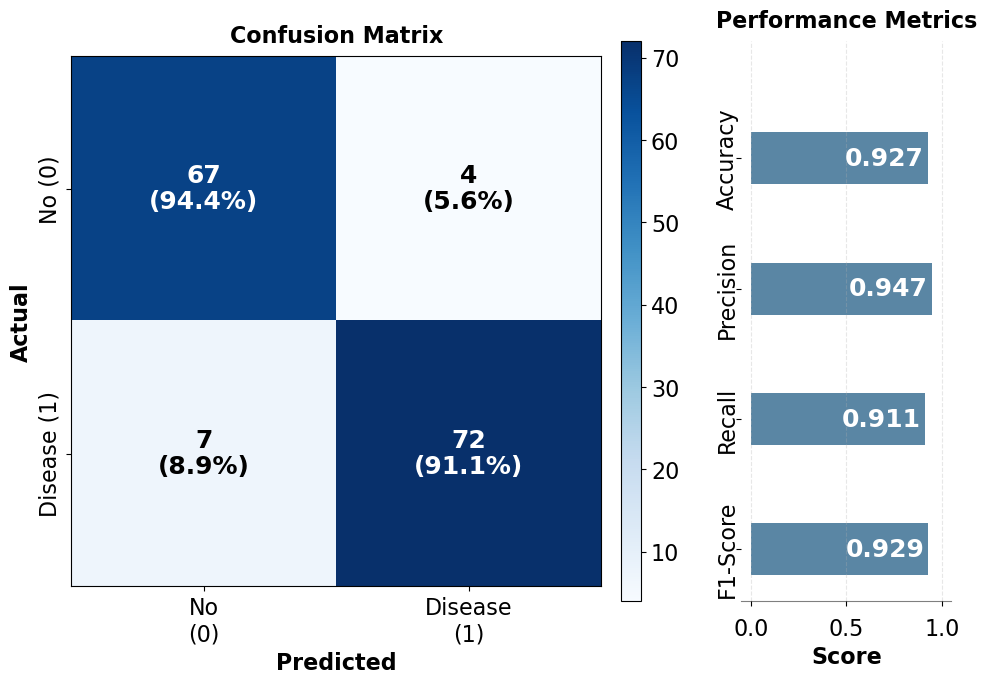

In [23]:
# Show SEL-NNML Evaluation Metrics
y_pred_stack = sel_nnml.predict(X_test)
evaluation_metrics_plot(y_test, y_pred_stack)

In [24]:
# Show SEL-NNM: all fold scores with mean and std 
sel_nnml_cv_scores = cross_val_score(sel_nnml, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=N_JOBS)
print(f'SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: {sel_nnml_cv_scores}')
print(f'Mean: {sel_nnml_cv_scores.mean():.4f}')
print(f'Standard Deviation: {sel_nnml_cv_scores.std():.4f}')

SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: [0.85833333 0.87394958 0.8907563  0.81512605 0.86554622]
Mean: 0.8607
Standard Deviation: 0.0252


In [25]:
# Show SELL-NNML Training Time
Total_training_time = base_models_training_time + meta_model_training_time
print(f'Base Models Tuning & Training Time: {base_models_training_time:.2f} seconds')
print(f'Meta Model Tuning & Training Time: {meta_model_training_time:.2f} seconds')
print(f'Total SEL-NNML Tuning & Training Time: {Total_training_time:.2f} seconds')

Base Models Tuning & Training Time: 240.69 seconds
Meta Model Tuning & Training Time: 111.65 seconds
Total SEL-NNML Tuning & Training Time: 352.34 seconds


### **6.2 Multiple Model Evaluation**

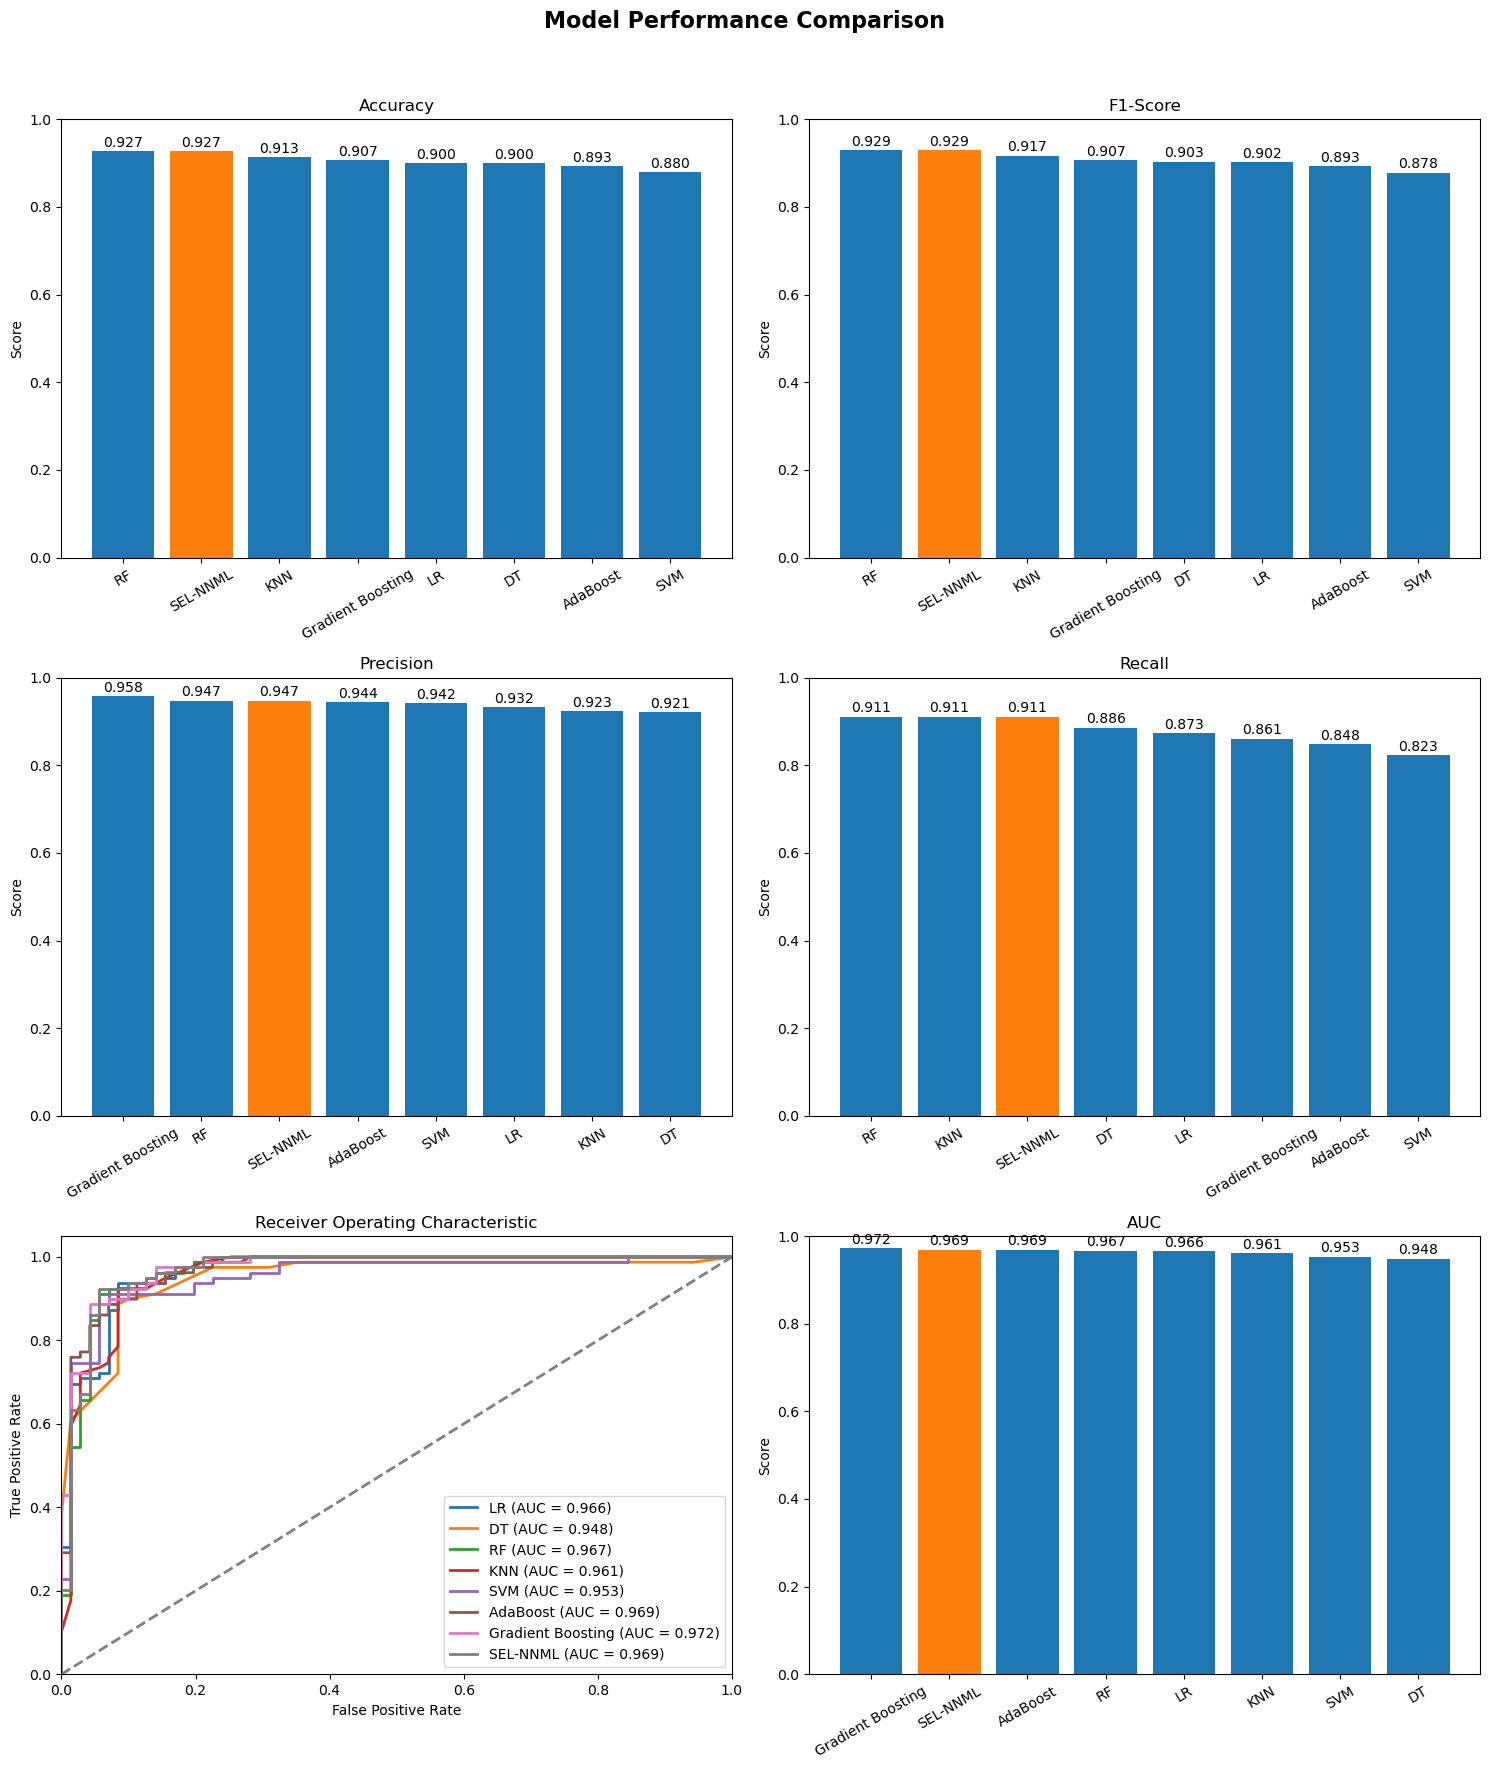

In [26]:
model_comparison_plot(all_models, X_test, y_test)

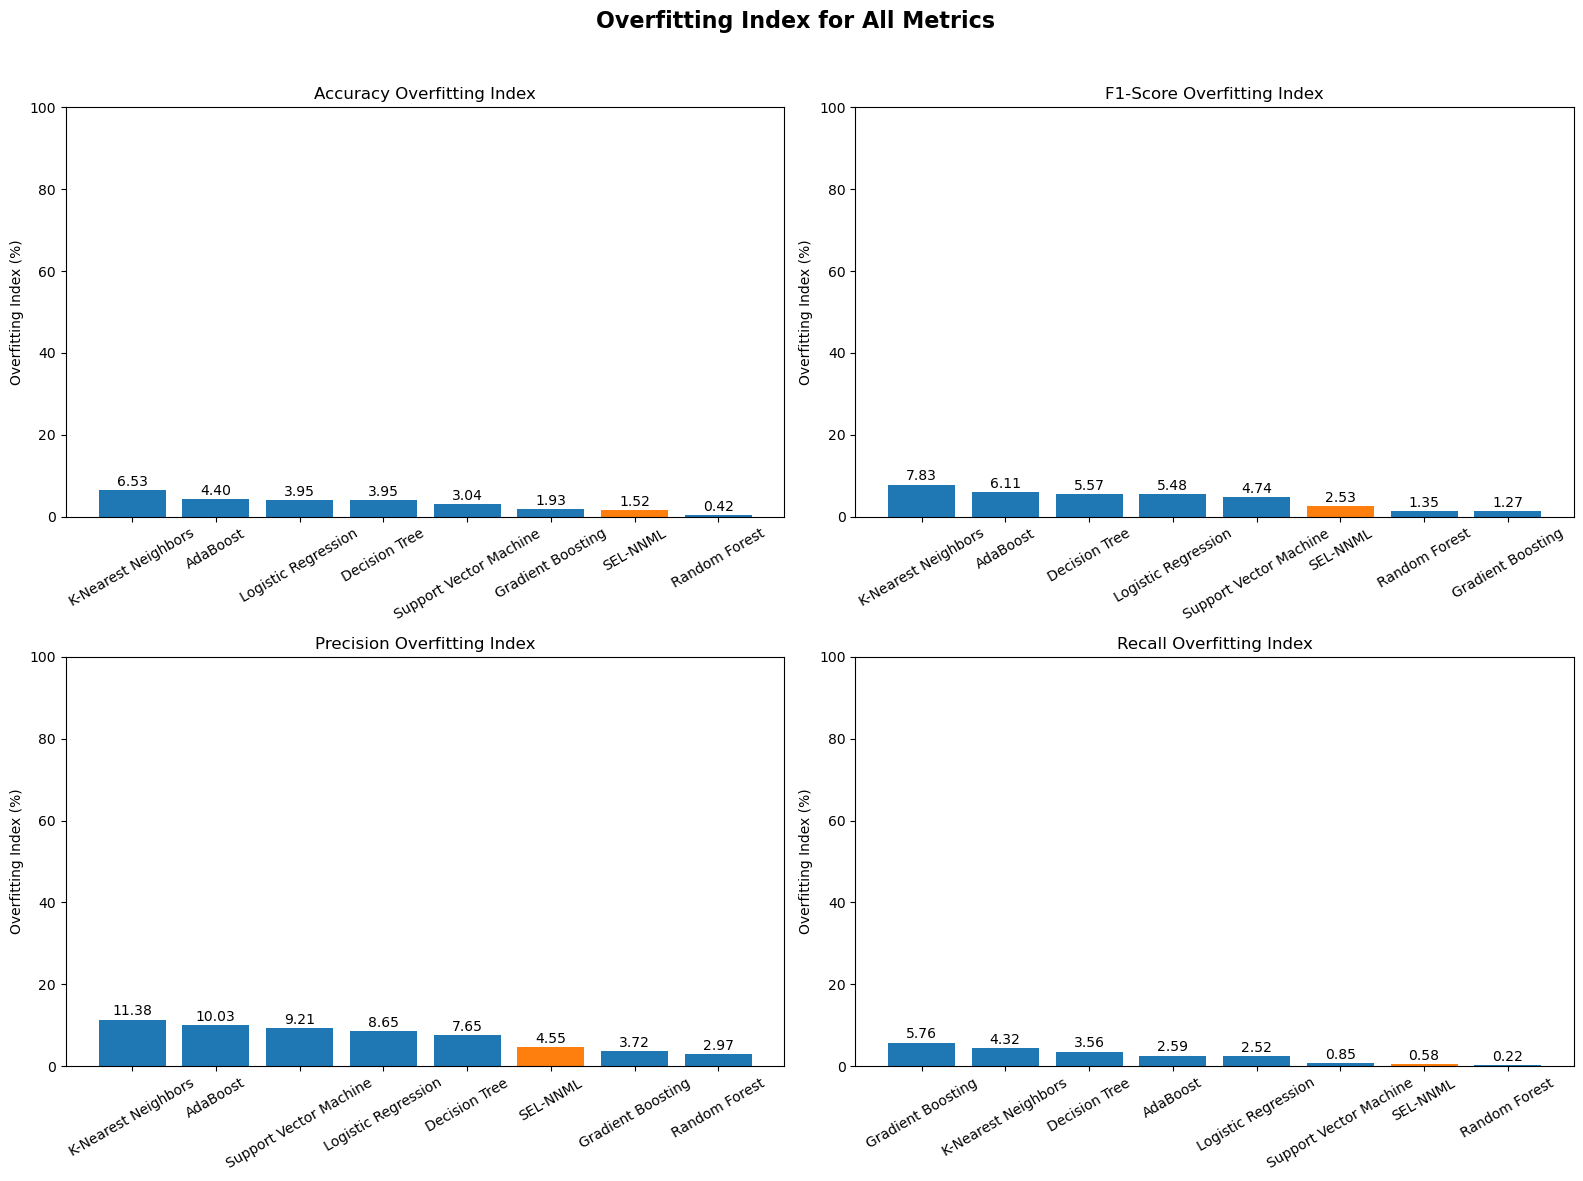

In [27]:
overfitting_index_plot(all_models, X_train, y_train, X_test, y_test)